# Features Discussion and Dummy Classifier Baseline

## Table of Contents

- [Data Takeover](#Data-Takeover)
- [Features Discussion](#Features-Discussion)
- [Train/Test Split](#Train/Test-Split)
- [PCA](#PCA)
- [Dummy Classifier](#Dummy-Classifier)
    - [Classifier Fit and Prediction](#Classifier-Fit-and-Prediction)
    - [Performance Measurement](#Performance-Measurement)
- [Results Handover](#Results-Handover)

## Data Takeover

Read in DataFrame from chapter [Feature Matrix Generation](./3_FeatureMatrixGeneration.ipynb) as input for processing in this chapter.

In [1]:
import os
import pandas as pd

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

df_labelled_feature_matrix.head()

,duplicates,coordinate_E_delta,coordinate_N_delta,corporate_110_delta,corporate_710_delta,doi_delta,edition_delta,exactDate_delta,format_prefix_delta,format_postfix_delta,...,musicid_delta,part_delta,person_100_delta,person_700_delta,person_245c_delta,pubinit_delta,scale_delta,ttlfull_245_delta,ttlfull_246_delta,volumes_delta
0,1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.75,1.0,1.0,...,-1.0,1.0,1.000000,1.0,1.000000,1.000000,-1.0,1.000000,-1.0,1.0
1,1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.75,1.0,1.0,...,-1.0,1.0,1.000000,0.0,0.818905,0.848485,-1.0,0.787879,-1.0,1.0
2,1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.75,1.0,1.0,...,-1.0,1.0,0.855556,0.0,0.697740,0.848485,-1.0,1.000000,-1.0,1.0
3,1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.75,1.0,1.0,...,-1.0,1.0,1.000000,0.0,0.818905,0.848485,-1.0,0.787879,-1.0,1.0
4,1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.75,1.0,1.0,...,-1.0,1.0,1.000000,-1.0,1.000000,1.000000,-1.0,1.000000,-1.0,1.0


In [2]:
print('Part of duplicates (1) on uniques (2) in units of [%]')
print(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100)

Part of duplicates (1) on uniques (2) in units of [%]
0    99.435054
1     0.564946
Name: duplicates, dtype: float64


## Features Discussion

By now, the features have become purely numerical values. In this section, the features of the feature matrix will be analysed and discussed deeper.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_feature_histogram (df, attrib) :
    plt.hist([df[attrib+'_delta'][df.duplicates==1],
              df[attrib+'_delta'][df.duplicates==0]],
             density=True, align='mid', color=['green', 'red'],
             label=['duplicates', 'uniques'])
    plt.title(f'{attrib} counts per similarity value')
    plt.xlabel('similarity value')
    plt.ylabel('number of counts in bin\n(normed to 1st bar height)')
    plt.legend()
    plt.show()

    return None

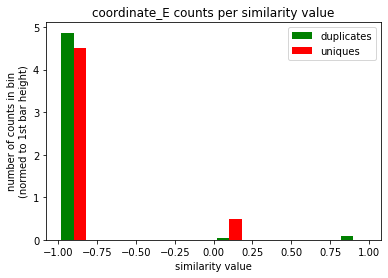

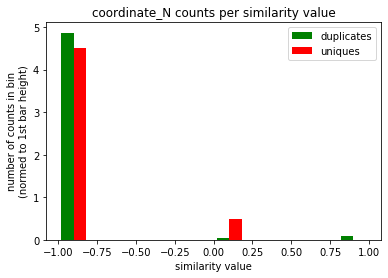

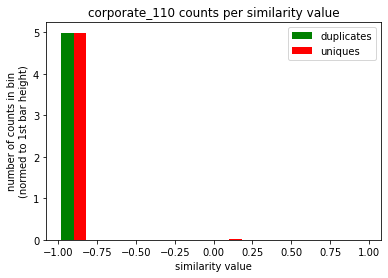

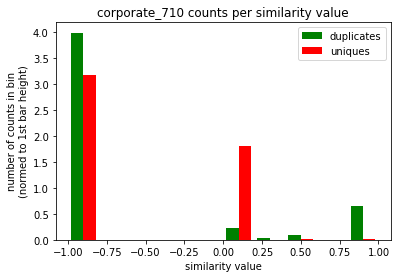

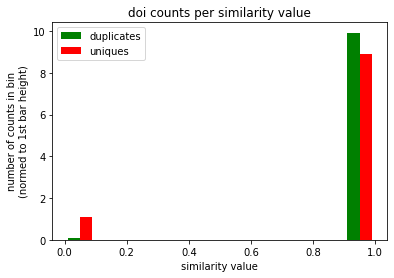

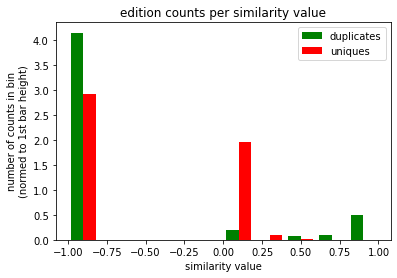

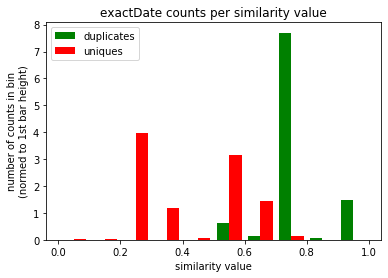

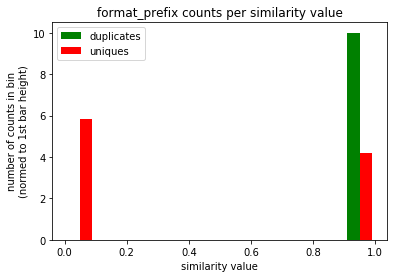

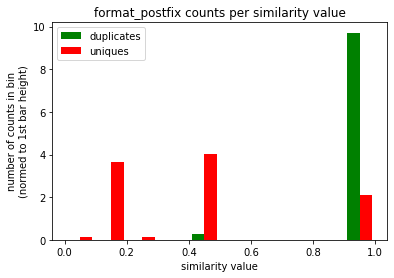

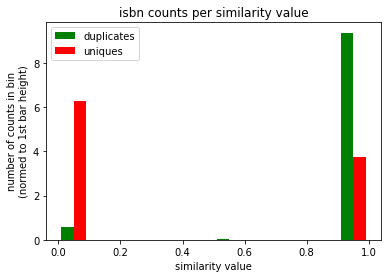

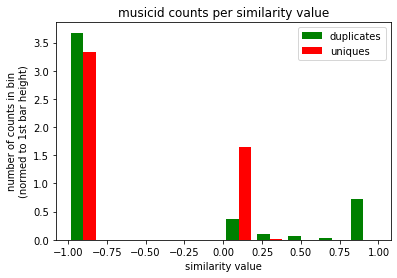

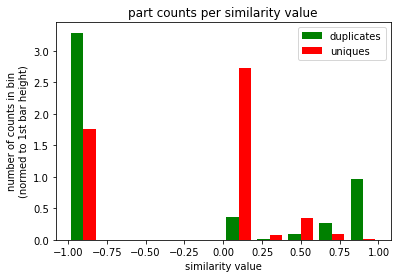

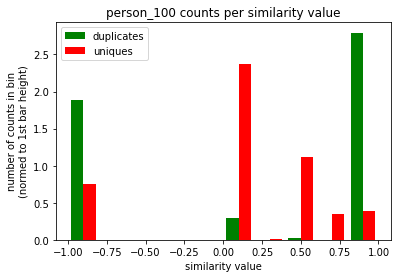

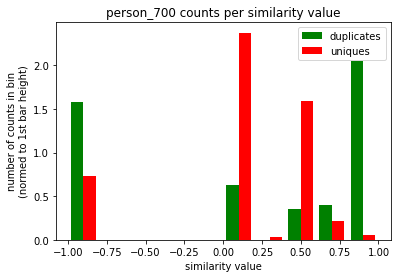

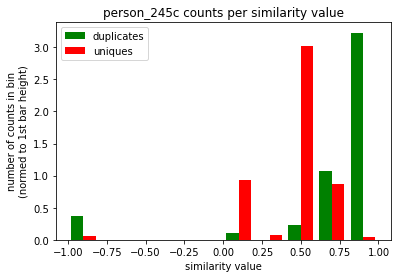

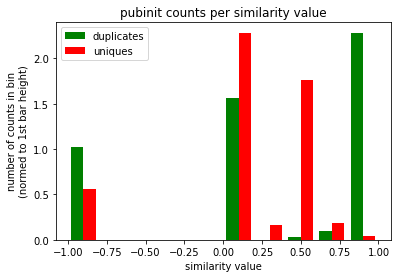

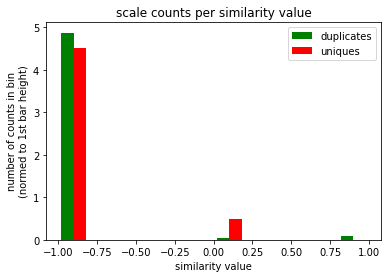

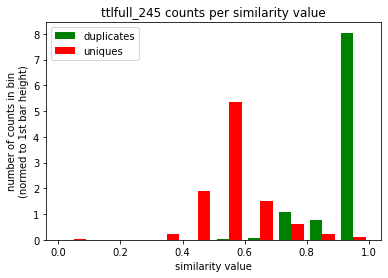

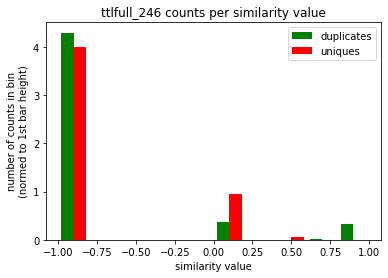

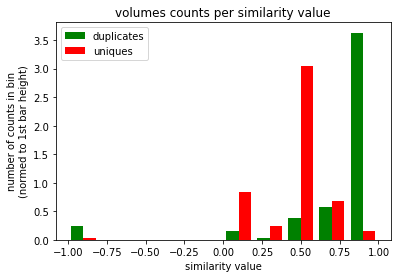

In [4]:
for i in df_labelled_feature_matrix.columns :
    if i not in ['duplicates'] :
        plot_feature_histogram(df_labelled_feature_matrix, i[:-6])

The values of attribute $\texttt{coordinate}$ have been modified such that missing values on both sides of the pair have been marked with a negative similarity value, see chapter [Feature Matrix Generation](./3_FeatureMatrixGeneration.ipynb). Ommitting negative values for the similarity delta shows the effect of the similarity value better.

In [5]:
def plot_feature_histogram_non_negative (df, attrib) :
    plt.hist([df[attrib+'_delta'][(df[attrib+'_delta']>=0.0) & (df.duplicates==1)],
              df[attrib+'_delta'][(df[attrib+'_delta']>=0.0) & (df.duplicates==0)]],
             density=True, align='mid', color=['green', 'red'],
             label=['duplicates', 'uniques'])
    plt.title(f'{attrib} counts per similarity value')
    plt.xlabel('similarity value')
    plt.ylabel('number of counts in bin\n(normed to 1st bar height)')
    plt.legend()
    plt.show()

    return None

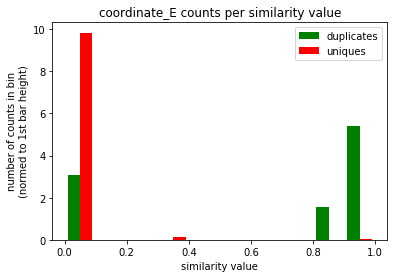

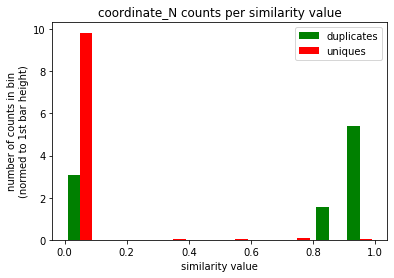

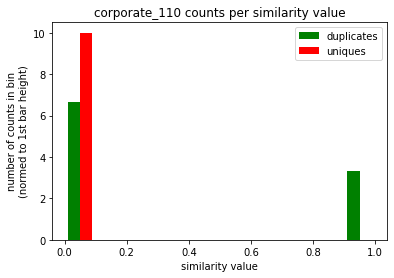

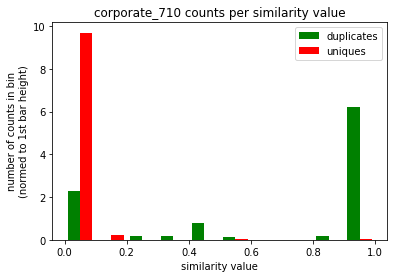

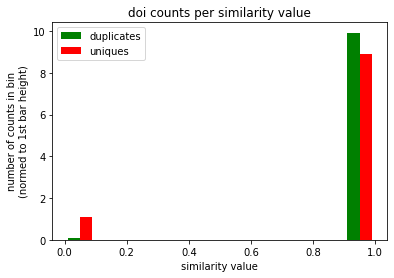

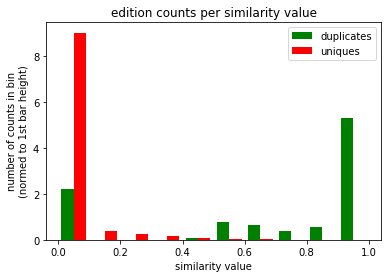

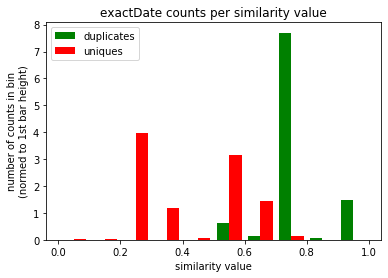

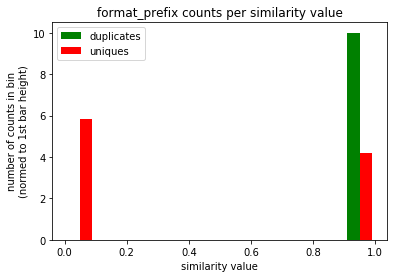

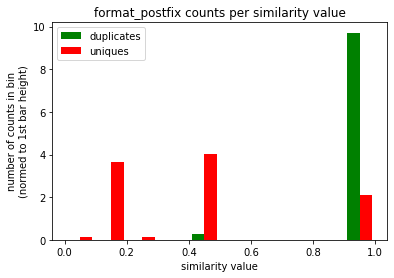

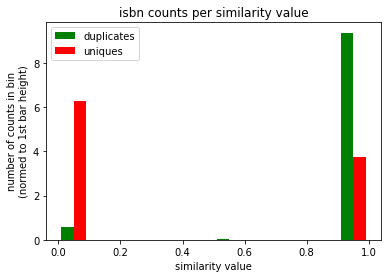

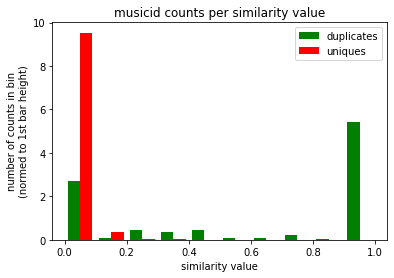

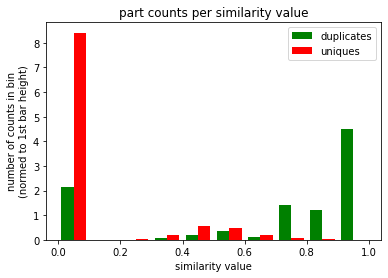

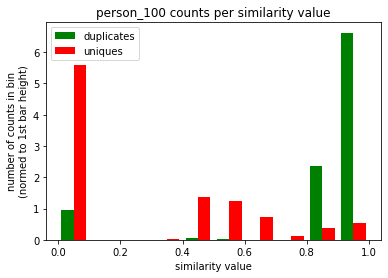

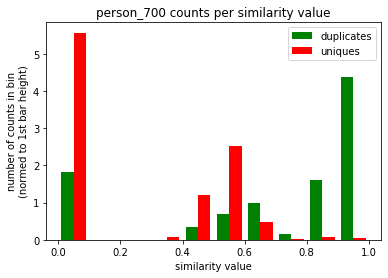

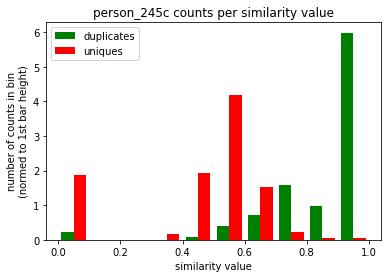

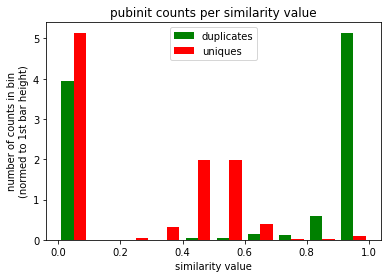

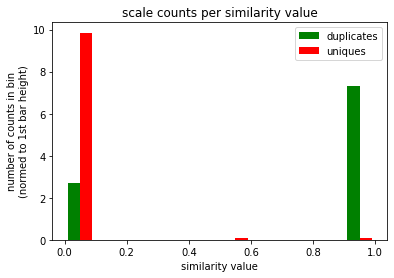

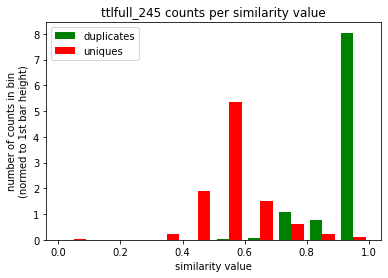

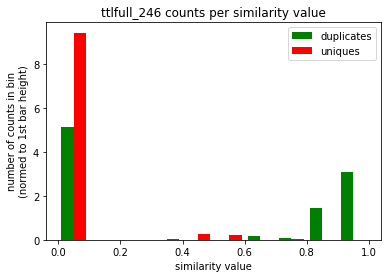

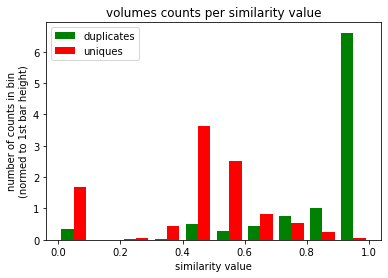

In [6]:
for i in df_labelled_feature_matrix.columns :
    if i not in ['duplicates'] :
        plot_feature_histogram_non_negative(df_labelled_feature_matrix, i[:-6])

### ttlfull_245 and ttlfull_246

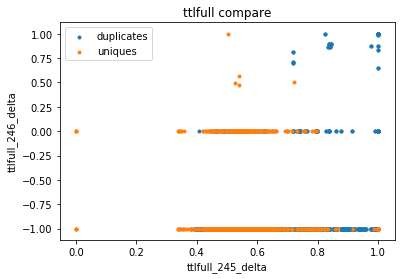

In [7]:
no_unique_samples = 1000
idx_duplicates = list(df_labelled_feature_matrix[df_labelled_feature_matrix.duplicates==1].index)
idx_uniques = list(df_labelled_feature_matrix[df_labelled_feature_matrix.duplicates==0].index)

plt.scatter(df_labelled_feature_matrix.loc[idx_duplicates].ttlfull_245_delta,
          df_labelled_feature_matrix.loc[idx_duplicates].ttlfull_246_delta,
        label='duplicates', marker='.')
plt.scatter(df_labelled_feature_matrix.loc[idx_uniques].ttlfull_245_delta.sample(n=no_unique_samples),
          df_labelled_feature_matrix.loc[idx_uniques].ttlfull_246_delta.sample(n=no_unique_samples),
        label='uniques', marker='.')

plt.title('ttlfull compare')
plt.xlabel('ttlfull_245_delta')
plt.ylabel('ttlfull_246_delta')
plt.legend()
plt.show()

## Train/Test Split

The train/test split will be implemented here as a general function to be called in the models chapters.

In [8]:
X = df_labelled_feature_matrix.drop(columns=['duplicates']).values
y = df_labelled_feature_matrix.duplicates.values

In [9]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

X_tr[:5], y_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        ,  1.        ,
         -1.        ,  0.5       ,  0.        ,  0.42857143,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.50165426,
          0.48593074, -1.        ,  0.60439973, -1.        ,  0.40277778],
        [-1.        , -1.        , -1.        ,  0.        ,  1.        ,
         -1.        ,  0.25      ,  0.        ,  0.42857143,  0.        ,
         -1.        , -1.        ,  0.        , -1.        ,  0.54435379,
          0.        , -1.        ,  0.54177001, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        ,  0.        ,  1.        ,
          0.        ,  0.25      ,  1.        ,  1.        ,  0.        ,
         -1.        ,  0.        ,  0.        ,  0.53663004,  0.6020276 ,
          0.49448622, -1.        ,  0.57046955, -1.        ,  0.57777778],
        [-1.        , -1.        , -1.        , -1.        ,  1.        ,
         -1.        ,  0.5       , 

In [10]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(208586, 20) (208586,) (52147, 20) (52147,)


## PCA

In [11]:
from sklearn.decomposition import PCA

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA
pca.fit(X, y=None) # Unsupervised learning, no y variable

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [12]:
# Proportion of variables explained
pve = pca.explained_variance_ratio_
pve

array([1.92359174e-01, 1.39853763e-01, 1.16753303e-01, 9.90795053e-02,
       7.32880867e-02, 7.15840571e-02, 6.17606701e-02, 5.59391507e-02,
       3.97521905e-02, 3.96153470e-02, 3.04677538e-02, 2.68303650e-02,
       1.67329879e-02, 1.36101596e-02, 1.04173945e-02, 7.22327337e-03,
       3.09237129e-03, 9.31449811e-04, 6.94010881e-04, 1.49860396e-05])

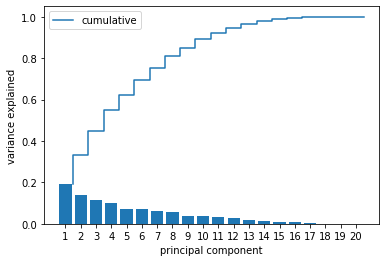

In [13]:
import numpy as np

# Create bar plot
xcor = np.arange(1, len(pve) + 1) # 1, 2, ..., n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5, 2.5, ..., n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.xlabel('principal component')
plt.ylabel('variance explained')
plt.legend()
plt.show()

In [14]:
# Create PCA transformer
pca_2 = PCA(n_components=2)

# Apply PCA
pca_2.fit(X, y=None) # Unsupervised learning, no y variable

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
# Project data onto the first two components
X_2d = pca_2.transform(X)

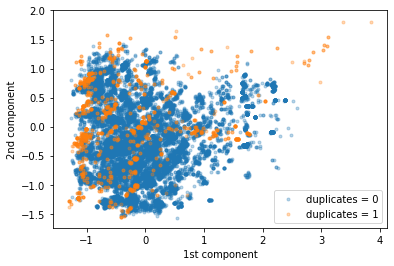

In [16]:
# Plot each kind of wine
for kind in [0, 1]:
    # Wine samples of this type
    idx = (y == kind)
    
    # Plot their components
    plt.scatter(
        X_2d[idx, 0][:20000], X_2d[idx, 1][:20000],
        label=f'duplicates = {kind}', marker='.', alpha=0.3
    )

# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

## Dummy Classifier

### Classifier Fit and Prediction

In [17]:
from sklearn.dummy import DummyClassifier

du = DummyClassifier(strategy='stratified', random_state=0)
du.fit(X_tr, y_tr)
y_pred = du.predict(X_te)

### Performance Measurement

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_te, y_pred)

array([[51571,   281],
       [  294,     1]])

In [19]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

print('Score {:.1f}%'.format(100*du.score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(
    100*roc_auc_score(y_te, y_pred),
                100*accuracy_score(y_te, y_pred),
                100*precision_score(y_te, y_pred),
                100*recall_score(y_te, y_pred)
               ))

Score 98.9%
Area under the curve 49.9% - accuracy 98.9% - precision 0.4% - recall 0.3%


## Results Handover

The DummyClassifier of this chapter is the first model and the entry point for saving performance results of all models of the capstone project. For storing the performance results of a model, a reusable function $\texttt{.add}\_\texttt{result}\_\texttt{to}\_\texttt{results}()$ has been implemented in a separate code file [results_saving_funcs.py](./results_saving_funcs.py). This function will be called at the end of every chapter with a new model calculated.

In [20]:
import results_saving_funcs as rsf

rsf.add_result_to_results(path_goldstandard, du, X_te, y_te, y_pred)